In [13]:
import os
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import seaborn as sns

from data.augment_data import setup_data_loaders
from models.resnet34 import resnet34
from training.trainer import train_model, evaluate_model

sns.set_style()

# Augmentacja danych

Oto skrócony opis poszczególnych transformacji:

1. `RandomResizedCrop(224)`: Losowo przycina obraz do rozmiaru 224x224 pikseli, co jest standardem dla wielu modeli wizji komputerowej.
2. `RandomHorizontalFlip()`: Losowo odbija obraz poziomo z prawdopodobieństwem 50%, pomagając modelowi lepiej radzić sobie z różnymi orientacjami obiektów.
3. `RandomRotation(15)`: Losowo obraca obraz o maksymalnie 15 stopni, co zwiększa odporność modelu na rotacje.
4. `ColorJitter`: Modyfikuje jasność, kontrast, nasycenie i odcień obrazu w losowy sposób, co pozwala modelowi pracować z obrazami w różnych warunkach oświetleniowych.
5. `RandomAffine`: Wykonuje losowe przesunięcia i skalowania obrazu, zachowując kąt niezmieniony, co symuluje różne perspektywy i odległości od obiektów.
6. `RandomPerspective`: Losowo zmienia perspektywę obrazu, co imituje różne punkty widzenia.
7. `ToTensor()`: Konwertuje obrazy na tensory PyTorch, co jest wymagane do przetwarzania w sieciach neuronowych.
8. `Normalize`: Normalizuje tensory obrazu stosując określoną średnią i odchylenie standardowe dla każdego kanału, dostosowując je do warunków, na których wstępnie trenowane były modele.

Te transformacje są kluczowe dla zwiększenia różnorodności danych treningowych, co pomaga modelowi generalizować lepiej i zmniejsza ryzyko przeuczenia.


In [ ]:
def get_train_transforms():
    return transforms.Compose(
        [
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(
                brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1
            ),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

In [ ]:
def get_test_val_transforms():
    return transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

In [ ]:
def setup_transform():
    return transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

In [ ]:
def load_data(data_path, transforms):
    dataset = ImageFolder(root=data_path, transform=transforms)
    print(f"Loaded {len(dataset)} images under {data_path}")
    return DataLoader(dataset, batch_size=1, shuffle=True)

In [4]:
def setup_data_loaders(base_path):
    train_loader = load_data(os.path.join(base_path, "train"), get_train_transforms())
    val_loader = load_data(os.path.join(base_path, "val"), get_test_val_transforms())
    test_loader = load_data(os.path.join(base_path, "test"), get_test_val_transforms())
    return train_loader, val_loader, test_loader

# Uczenie modelu

Funkcja `train_model` jest odpowiedzialna za trening modelu sieci neuronowej. Przyjmuje ona szereg argumentów, w tym model do trenowania, ładowacze danych dla zestawów treningowego i walidacyjnego, funkcję straty, optymalizator, liczbę epok, urządzenie (np. GPU), oraz ścieżkę do zapisu najlepszego modelu.

### Proces treningu:
1. **Inicjalizacja:** Najlepsza dokładność walidacji jest inicjalizowana na 0.0.
2. **Pętla po epokach:** Dla każdej epoki:
   - Model jest ustawiany w tryb treningu.
   - Inicjalizowane są zmienne do śledzenia straty i liczby poprawnych predykcji.
   - **Pętla po partiach danych treningowych:**
     - Dane są przenoszone na odpowiednie urządzenie.
     - Gradienty są zerowane.
     - Obliczane są predykcje modelu, strata jest obliczana i propagowana wstecz, a optymalizator aktualizuje parametry modelu.
     - Akumulacja straty i poprawnych predykcji.
   - Po przetworzeniu wszystkich partii, obliczana jest średnia strata i dokładność dla epoki.
   - Wyświetlane są statystyki epoki.

3. **Walidacja:** Po każdej epoce przeprowadzana jest walidacja, obliczane są strata i dokładność walidacyjna.
   - Jeśli dokładność walidacji jest lepsza niż dotychczas najlepsza, model jest zapisywany.

4. **Zakończenie treningu:** Wyświetlana jest informacja o zakończeniu treningu.

Funkcja ta umożliwia efektywne trenowanie modeli, monitorowanie ich postępu i zapisywanie najlepszego modelu na podstawie dokładności walidacyjnej.


In [ ]:
def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs,
    device,
    best_model_path,
):
    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(
            f"Epoch {epoch+1}/{num_epochs} - Training loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}"
        )

        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
        print(f"Validation Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            torch.save(model.state_dict(), best_model_path)
            print("Saving best model")

    print("Training complete")

# Ewaluacja modelu

Funkcja `evaluate_model` służy do oceny modelu sieci neuronowej na podstawie dostarczonego zestawu danych. Jest używana głównie do walidacji modelu lub testowania jego skuteczności po treningu.

### Proces oceny modelu:
1. **Ustawienie modelu w tryb ewaluacji:** Przełącza model na `eval` mode, co deaktywuje warstwy takie jak Dropout czy BatchNorm.
2. **Inicjalizacja zmiennych:** Zerowanie zmiennych do śledzenia całkowitej straty i liczby poprawnych predykcji.
3. **Pętla przez zestaw danych:**
   - Przenoszenie danych wejściowych i etykiet na wybrane urządzenie (np. GPU).
   - Wyłączenie obliczania gradientów, co jest standardowym krokiem podczas ewaluacji, aby oszczędzić zasoby i przyspieszyć obliczenia.
   - Obliczanie predykcji modelu, straty oraz aktualizacja zmiennych śledzących wyniki.
4. **Obliczenie średniej straty i dokładności:** Po przejściu przez wszystkie dane, obliczana jest średnia strata oraz dokładność modelu na podstawie akumulowanych wartości.
5. **Zwracanie wyników:** Funkcja zwraca średnią stratę i dokładność, które mogą być użyte do dalszej analizy wyników modelu.

In [ ]:
def evaluate_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    total_loss = running_loss / len(loader.dataset)
    total_acc = running_corrects.double() / len(loader.dataset)
    return total_loss, total_acc

# Główna funkcja

Funkcja `main()` stanowi główny punkt wejścia do skryptu trenującego model wizji komputerowej z użyciem architektury ResNet-34. Skrypt przygotowuje i uruchamia trening, a następnie ocenia model.

### Proces działania funkcji `main()`:
1. **Konfiguracja urządzenia:** Określa, czy trenowanie będzie przeprowadzane na GPU (jeśli dostępne) czy na CPU.
2. **Inicjalizacja modelu:** Ładuje wstępnie nauczony model ResNet-34 i dostosowuje go do klasyfikacji 15 klas.
3. **Przygotowanie danych:** Ładuje dane treningowe, walidacyjne i testowe z określonej ścieżki.
4. **Definicja funkcji straty i optymalizatora:** Używa CrossEntropyLoss i SGD z określonymi parametrami dla optymalizacji.
5. **Uruchomienie procesu trenowania:** Przeprowadza trening modelu przez określoną liczbę epok i zapisuje najlepszy model.
6. **Wczytanie najlepszego modelu:** Ładuje najlepszy stan modelu z dysku.
7. **Ocena modelu na danych testowych:** Wykonuje ocenę modelu na zbiorze testowym i wypisuje strata i dokładność testowa.


In [ ]:
def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = resnet34(pretrained=True, num_classes=15)
    model = model.to(device)

    base_path = "/home/artur_176/CNN/CNN/datasets/processed"
    train_loader, val_loader, test_loader = setup_data_loaders(base_path)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    num_epochs = 25
    best_model_path = "best_model.pth"
    train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        num_epochs,
        device,
        best_model_path,
    )

    model.load_state_dict(torch.load(best_model_path))
    test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")


if __name__ == "__main__":
    main()

## Model ResNet-34

Model **ResNet34** jest częścią rodziny architektur **Residual Network (ResNet)**, zaprojektowanej do rozwiązywania problemów związanych z trenowaniem bardzo głębokich sieci neuronowych. Został wprowadzony przez Kaiming He i współpracowników w 2015 roku. 

### Kluczowe cechy ResNet34:
- **Bloki residualne**: Zawiera bloki residualne z połączeniami pomijającymi (skip connections), które umożliwiają przekazywanie sygnału wejściowego bezpośrednio do głębszych warstw, redukując problem zanikającego gradientu.
- **Normalizacja wsadowa**: Każda warstwa konwolucyjna jest następowana przez warstwę normalizacji wsadowej, co stabilizuje uczenie i przyspiesza konwergencję.
- **Funkcje aktywacji**: Wykorzystuje funkcje aktywacji ReLU dla dodatkowej nieliniowości.
- **Globalne uśrednianie puli**: Zamiast tradycyjnych w pełni połączonych warstw, ResNet34 używa globalnego uśredniania puli, co zmniejsza ryzyko przeuczenia i liczbę parametrów.

### Zastosowania:
ResNet34 jest szeroko stosowany w rozpoznawaniu obrazów, analizie wideo i innych zastosowaniach wizji komputerowej, często z wykorzystaniem modeli wstępnie wytrenowanych na dużych zbiorach danych, takich jak ImageNet.

### Wstępne trenowanie:
Dzięki dostępności jako wstępnie wytrenowany model, ResNet34 umożliwia efektywne transferowanie nauki (transfer learning) i dostosowywanie do specyficznych zadań poprzez fine-tuning, co poprawia wydajność i skraca czas potrzebny na trening.

## Funkcja straty - CrossEntropyLoss

`CrossEntropyLoss`, czyli funkcja straty entropii krzyżowej, jest często używana w uczeniu maszynowym jako funkcja straty w problemach klasyfikacji wieloklasowej. Mierzy ona skuteczność modelu klasyfikacyjnego, którego wyjście stanowi prawdopodobieństwo przyjmujące wartości między 0 a 1. Strata entropii krzyżowej rośnie, gdy przewidywane prawdopodobieństwo oddala się od rzeczywistej etykiety.

Dana jest ona wzorem:

$$
\text{CrossEntropyLoss} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{c=1}^{C} y_{i,c} \log(p_{i,c})
$$

Gdzie:
- $N$ to liczba próbek w partii.
- $C$ to liczba klas.
- $y_{i,c}$ to wskaźnik binarny (0 lub 1), który wskazuje, czy klasa $c$ jest poprawną klasyfikacją dla obserwacji $i$.
- $p_{i,c}$ to przewidywane prawdopodobieństwo, że obserwacja $i$ należy do klasy $c$.

Funkcja ta skupia się na prawdopodobieństwie przypisanym do faktycznej etykiety klasy (jak wskazuje wskaźnik $y_{i,c}$) i penalizuje odchylenie prawdopodobieństwa od 1 poprzez użycie funkcji logarytmicznej $ \log(p_{i,c}) $. Funkcja logarytmiczna jest użyteczna, ponieważ ostro penalizuje model, kiedy dokona on pewnej, ale błędnej predykcji.


## Optymalizator - SGD

`SGD`, czyli metoda stochastycznego spadku gradientu (Stochastic Gradient Descent), jest popularnym algorytmem optymalizacyjnym używanym w uczeniu maszynowym, szczególnie w uczeniu głębokim. Metoda ta służy do minimalizacji funkcji straty modelu, co zwykle prowadzi do lepszego dopasowania modelu do danych.

Podstawowa idea SGD polega na tym, że zamiast obliczać dokładny gradient funkcji straty względem wszystkich danych w zestawie danych, oblicza się gradient na podstawie jednego wybranego losowo przykładu (lub małej grupy przykładów, tzw. mini-batch). Dzięki temu każdy krok w kierunku minimum funkcji straty jest szybszy i mniej zasobożerny.

Oto wzór na aktualizację parametrów w SGD:

$$
\theta_{t+1} = \theta_t - \eta \nabla_{\theta} J(\theta_t, x^{(i)}, y^{(i)})
$$

Gdzie:
- $ \theta $ to parametry modelu.
- $ \eta $ to współczynnik uczenia (learning rate).
- $ \nabla_{\theta} J $ to gradient funkcji straty $ J $ względem parametrów $ \theta $, obliczony przy użyciu pojedynczego przykładu danych $ (x^{(i)}, y^{(i)}) $ lub mini-batcha.
- $ t $ to numer iteracji.

Metoda ta jest efektywna, szczególnie w dużych zbiorach danych, ponieważ pozwala na szybsze i częstsze aktualizacje parametrów, co może przyspieszyć zbieżność algorytmu. Jednakże, ze względu na swoją stochastyczną naturę, trajektoria poszukiwania minimum jest bardziej nieregularna niż w przypadku metod gradientowych bazujących na pełnym zbiorze danych.

## Wykres dokładności i straty

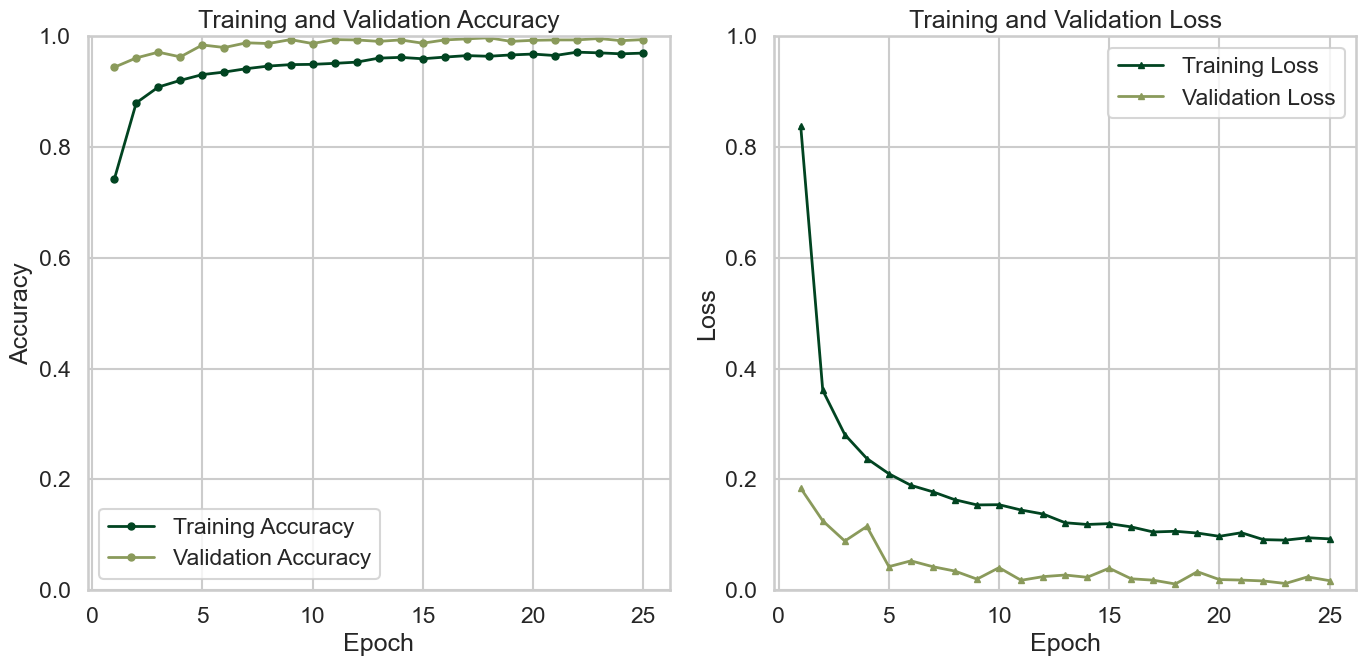

In [14]:
# Wykres dokładności i strat
epochs = list(range(1, 26))  # 25 epok

# Dokładność
train_acc = [0.7415, 0.8799, 0.9084, 0.9205, 0.9309, 0.9355, 0.9416, 0.9463, 0.9489, 0.9494, 0.9512, 0.9534, 0.9606, 0.9620, 0.9595, 0.9625, 0.9652, 0.9640, 0.9664, 0.9680, 0.9653, 0.9714, 0.9702, 0.9684, 0.9697]
val_acc = [0.9441, 0.9610, 0.9714, 0.9629, 0.9844, 0.9798, 0.9883, 0.9870, 0.9941, 0.9870, 0.9941, 0.9935, 0.9909, 0.9935, 0.9876, 0.9935, 0.9954, 0.9974, 0.9909, 0.9928, 0.9935, 0.9935, 0.9961, 0.9922, 0.9941]

# Straty
train_loss = [0.8377, 0.3606, 0.2808, 0.2376, 0.2101, 0.1892, 0.1774, 0.1631, 0.1538, 0.1542, 0.1446, 0.1374, 0.1216, 0.1185, 0.1200, 0.1141, 0.1049, 0.1062, 0.1030, 0.0971, 0.1036, 0.0911, 0.0902, 0.0945, 0.0925]
val_loss = [0.1839, 0.1250, 0.0886, 0.1149, 0.0423, 0.0528, 0.0422, 0.0343, 0.0198, 0.0405, 0.0177, 0.0243, 0.0272, 0.0231, 0.0395, 0.0204, 0.0179, 0.0110, 0.0332, 0.0190, 0.0181, 0.0165, 0.0119, 0.0238, 0.0170]

# Ustawienia stylów dla wykresów
#plt.style.use('seaborn-darkgrid')  # Styl tła i siatki

# Tworzenie wykresów
plt.figure(figsize=(14, 7))

# Wykres dokładności
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'o-', label='Training Accuracy', linewidth=2, markersize=5, color='#014421')
plt.plot(epochs, val_acc, 'o-', label='Validation Accuracy', linewidth=2, markersize=5, color='#8a9a5b')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0, 1])  # Zakres osi y

# Wykres strat
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, '^-', label='Training Loss', linewidth=2, markersize=5, color='#014421')
plt.plot(epochs, val_loss, '^-', label='Validation Loss', linewidth=2, markersize=5, color='#8a9a5b')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim([0, 1])  # Zakres osi y, dostosuj w razie potrzeby

plt.tight_layout()
plt.show()
